In [1]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax

# constructing the telescope:
wf_npixels = 128 # 128 lowest power of 2 necessary
diameter = 0.125 #
period = 304e-6 
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

import jax.random as jr
key = 0

psf_npixels = 300
assumed_pixel_scale = 0.375
true_pixel_scale = assumed_pixel_scale*jr.uniform(jr.PRNGKey(key), minval=0.9, maxval=1.1)
print(true_pixel_scale)
oversample = 4 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,true_pixel_scale,oversample)

0.36888427


In [13]:
import pandas as pd
from scipy.stats import binned_statistic

# Step 1: Load from CSV
df = pd.read_csv("alpha_cen_A_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask = (df["wavelength"] >= 5200) & (df["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths = df["wavelength"][mask].to_numpy() * 1e-10  # meters
weights = df["flux"][mask].to_numpy()

# Step 4: Downsample using binning
n_bins = 500
bin_means, bin_edges, _ = binned_statistic(
    wavelengths, weights, statistic='mean', bins=n_bins
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 5: Create the point source
flux_single_exposure = 2.909*10**7 # from max charles code
n_exposures = 4000 # (4 sidelobes, 1000 exposures = 500 seconds of exposure time)

# normalising the weights
weights_norm = bin_means/np.sum(bin_means)

# modify the weights with a normal distribution on each
std = 0.04
epsilon = 1e-6 # no weight can be below this.
weights_modified = weights_norm * np.maximum((1 + std * jr.normal(jr.PRNGKey(key),n_bins)), epsilon * np.ones(n_bins))

alpha_cen_a_source = dl.PointSource(
    wavelengths=bin_centers,
    weights=weights_modified,
    flux= n_exposures*flux_single_exposure
)

In [14]:
alpha_cen_a_scope = dl.Telescope(optics,alpha_cen_a_source)

sidelobescope = dlT.SideLobeTelescope(alpha_cen_a_scope, period, difference)

In [15]:
# going to use the model for a single sidelobe rather than all 4. 
# saves a lot of memory / makes calculation quicker
# basically no difference in information content so long as source is centered
center_wl = 585e-9

sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)

Model time: 20.7235 seconds.


In [16]:
sidelobe_poisson = jr.poisson(jr.PRNGKey(key),sidelobe_raw)

In [17]:
# add pixel scale optimiser
weights_path = 'telescope.source.spectrum.weights'
pixel_scale_path = 'telescope.optics.psf_pixel_scale'

parameters = [weights_path, pixel_scale_path]

# initial guess for weights
model = sidelobescope.set(weights_path, weights_norm)

# initial guess for pixel scale
model = model.set(pixel_scale_path, np.array(assumed_pixel_scale))

# Optimisation
import zodiax as zdx
import optax

# want to optimise pixel scale immediately, then do weights
pixel_scale_optimiser = optax.adam(5e-4) # half what it used to be

# bascially 0 learning rate until 50th iteration.
weights_sched = optax.piecewise_constant_schedule(init_value=1e-5*1e-8,
                                                  boundaries_and_scales={50 : int(1e8)}) 

weights_optimiser = optax.adam(weights_sched)

optimisers = [weights_optimiser, pixel_scale_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [18]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [19]:
%%time
loss, grads = loss_fn(model, sidelobe_poisson) # Compile
print("Initial Loss: {}".format(int(loss)))

Model time: 8.1006 seconds.
Initial Loss: 480061952
CPU times: user 4min 55s, sys: 22.8 s, total: 5min 18s
Wall time: 3min 4s


In [20]:
from tqdm import tqdm

losses, models_out = [], []
with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobe_poisson)

        updates, opt_state = optim.update(grads, opt_state)

        # # prevent negative weights
        # # Get current weights
        weights = model.get(weights_path)

        #print(weights[0])
        # # Get update for weights
        weight_updates = updates.get(weights_path)
        #print(weight_updates[0])
        # # Clamp the update: ensure weights + update >= 0
        # already have epsilon defined above
        safe_updates = np.where(weights + weight_updates < epsilon, epsilon-weights, weight_updates)

        # Create a copy of updates and replace the weights update with safe update
        updates = updates.set(weights_path, safe_updates)
        # print("Pixel scale grad:", grads.get(pixel_scale_path))
        # print("Pixel scale update:", updates.get(pixel_scale_path))

        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Log Loss: 8.681:   0%|          | 1/200 [00:50<2:47:04, 50.38s/it]

Model time: 9.4484 seconds.


Log Loss: 5.627: 100%|██████████| 200/200 [3:11:49<00:00, 57.55s/it]  


In [ ]:
pixel_scales_found  = np.array([model.get(pixel_scale_path) for model in models_out])

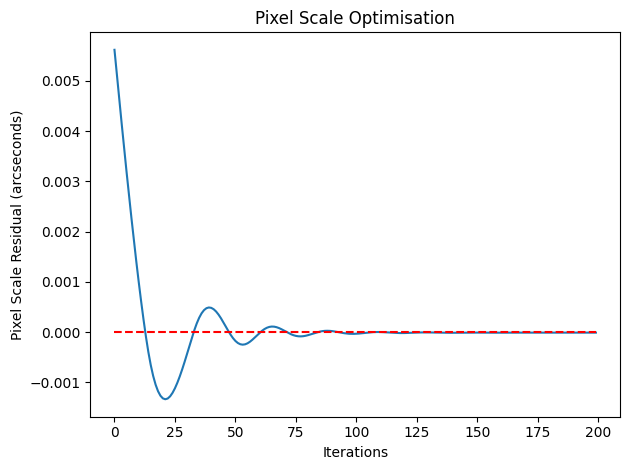

In [23]:
plt.title('Pixel Scale Optimisation')
plt.plot(pixel_scales_found-true_pixel_scale)
plt.plot(np.zeros(200),linestyle='--',color='red')
plt.xlabel('Iterations')
plt.ylabel('Pixel Scale Residual (arcseconds)')
plt.tight_layout()
#plt.savefig('pixel_scale_res.pdf')
plt.show()

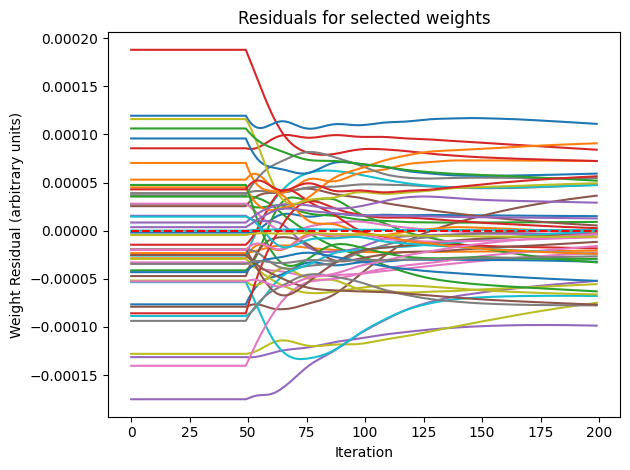

In [32]:

weights_residuals = np.array([

        (models_out[it].telescope.source.spectrum.weights / np.sum(models_out[it].telescope.source.spectrum.weights)
        - weights_modified)
    
    for it in np.arange(200)
])

for i in range(0, weights_residuals.shape[1], 10):  # every 10th rate index
    plt.plot(weights_residuals[:, i], label=f'Rate {i}')

plt.plot(np.zeros(200),linestyle='--',color='red')
plt.xlabel("Iteration")
plt.ylabel("Weight Residual (arbitrary units)")
plt.title("Residuals for selected weights")
plt.tight_layout()
#plt.savefig('weights_res.pdf')
plt.show()

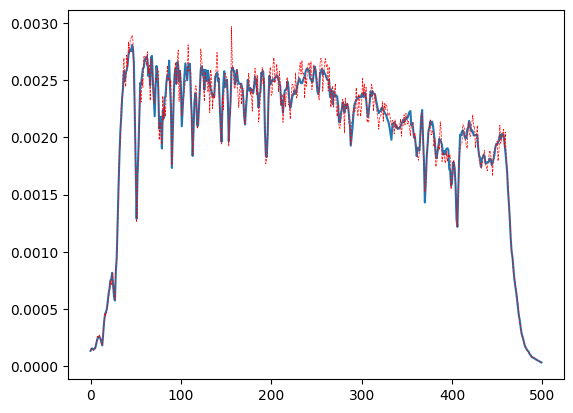

In [ ]:
plt.plot(weights_norm)
plt.plot(weights_modified, color='red',linestyle='--',linewidth=0.5)
plt.show()

In [ ]:
# max says to use a different optimiser for pixel scale, not adam
# instead use sgd stochastic gradient descent, apparently less bouncy

NameError: name 'plt' is not defined